In [1]:
# copy paste from simulate_pixels.py
from math import ceil
from time import time

import numpy as np
import numpy.lib.recfunctions as rfn

import cupy as cp
from cupy.cuda.nvtx import RangePush, RangePop

import fire
import h5py

from numba.cuda import device_array
from numba.cuda.random import create_xoroshiro128p_states

from tqdm import tqdm

from larndsim import consts
from larndsim.cuda_dict import CudaDict

SEED = int(time())

def swap_coordinates(tracks):
    """
    Swap x and z coordinates in tracks.
    This is because the convention in larnd-sim is different
    from the convention in edep-sim. FIXME.

    Args:
        tracks (:obj:`numpy.ndarray`): tracks array.

    Returns:
        :obj:`numpy.ndarray`: tracks with swapped axes.
    """
    x_start = np.copy(tracks['x_start'] )
    x_end = np.copy(tracks['x_end'])
    x = np.copy(tracks['x'])

    tracks['x_start'] = np.copy(tracks['z_start'])
    tracks['x_end'] = np.copy(tracks['z_end'])
    tracks['x'] = np.copy(tracks['z'])

    tracks['z_start'] = x_start
    tracks['z_end'] = x_end
    tracks['z'] = x

    return tracks

def maybe_create_rng_states(n, seed=0, rng_states=None):
    """Create or extend random states for CUDA kernel"""
    if rng_states is None:
        return create_xoroshiro128p_states(n, seed=seed)
    elif n > len(rng_states):
        new_states = device_array(n, dtype=rng_states.dtype)
        new_states[:len(rng_states)] = rng_states
        new_states[len(rng_states):] = create_xoroshiro128p_states(n - len(rng_states), seed=seed)
        return new_states
    return rng_states

In [2]:
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import cupy as cp
from larndsim.consts.light import LIGHT_TRIG_WINDOW, LIGHT_DIGIT_SAMPLE_SPACING, LIGHT_TICK_SIZE

In [3]:
pixel_layout = '../larndsim/pixel_layouts/multi_tile_layout-2.3.16.yaml'
detector_properties = '../larndsim/detector_properties/module0.yaml'
response_file = '../larndsim/bin/response_44.npy'
bad_channels = '../larndsim/detector_properties/module0_bad_channels.json'
pixel_thresholds_file = None
light_lut_filename = '../larndsim/bin/lightLUT.npy'
light_det_noise_filename = '../larndsim/bin/light_noise.npy'

input_filename = '../edep.9951.h5'

In [4]:
# copy paste from simulate_pixels.py
BATCH_SIZE = 4000

start_simulation = time()

RangePush("run_simulation")

print("**************************\nLOADING SETTINGS AND INPUT\n**************************")
print("Random seed:", SEED)
print("Batch size:", BATCH_SIZE)
print("Pixel layout file:", pixel_layout)
print("Detector properties file:", detector_properties)
print("edep-sim input file:", input_filename)
print("Response file:", response_file)
if bad_channels:
    print("Disabled channel list: ", bad_channels)
RangePush("load_detector_properties")
consts.load_properties(detector_properties, pixel_layout)
from larndsim.consts import light, detector, physics
RangePop()

RangePush("load_larndsim_modules")
# Here we load the modules after loading the detector properties
# maybe can be implemented in a better way?
from larndsim import (quenching, drifting, detsim, pixels_from_track, fee,
    lightLUT, light_sim)
RangePop()

RangePush("load_pixel_thresholds")
if pixel_thresholds_file is not None:
    print("Pixel thresholds file:", pixel_thresholds_file)
    pixel_thresholds_lut = CudaDict.load(pixel_thresholds_file, 256)
else:
    pixel_thresholds_lut = CudaDict(cp.array([fee.DISCRIMINATION_THRESHOLD]), 1, 1)
RangePop()

RangePush("load_hd5_file")
# First of all we load the edep-sim output
with h5py.File(input_filename, 'r') as f:
    tracks = np.array(f['segments'])
    try:
        trajectories = np.array(f['trajectories'])
        input_has_trajectories = True
    except KeyError:
        input_has_trajectories = False

    try:
        vertices = np.array(f['vertices'])
        input_has_vertices = True
    except KeyError:
        print("Input file does not have true vertices info")
        input_has_vertices = False

RangePop()

# Makes an empty array to store data from lightlut
if light.LIGHT_SIMULATED:
    light_sim_dat = np.zeros([len(tracks), light.N_OP_CHANNEL],
                             dtype=[('n_photons_det','f4'),('t0_det','f4')])
    track_light_voxel = np.zeros([len(tracks), 3], dtype='i4')

if tracks.size == 0:
    print("Empty input dataset, exiting")
    
else:

    n_tracks = len(tracks)
    if n_tracks:
        tracks = tracks[:n_tracks]
        if light.LIGHT_SIMULATED:
            light_sim_dat = light_sim_dat[:n_tracks]

    if 'n_photons' not in tracks.dtype.names:
        n_photons = np.zeros(tracks.shape[0], dtype=[('n_photons', 'f4')])
        tracks = rfn.merge_arrays((tracks, n_photons), flatten=True)

    # Here we swap the x and z coordinates of the tracks
    # because of the different convention in larnd-sim wrt edep-sim
    tracks = swap_coordinates(tracks)

    response = cp.load(response_file)

    TPB = 256
    BPG = ceil(tracks.shape[0] / TPB)

    print("******************\nRUNNING SIMULATION\n******************")
    # We calculate the number of electrons after recombination (quenching module)
    # and the position and number of electrons after drifting (drifting module)
    print("Quenching electrons..." , end="")
    start_quenching = time()
    quenching.quench[BPG,TPB](tracks, physics.BIRKS)
    end_quenching = time()
    print(f" {end_quenching-start_quenching:.2f} s")

    print("Drifting electrons...", end="")
    start_drifting = time()
    drifting.drift[BPG,TPB](tracks)
    end_drifting = time()
    print(f" {end_drifting-start_drifting:.2f} s")

**************************
LOADING SETTINGS AND INPUT
**************************
Random seed: 1649707027
Batch size: 4000
Pixel layout file: ../larndsim/pixel_layouts/multi_tile_layout-2.3.16.yaml
Detector properties file: ../larndsim/detector_properties/module0.yaml
edep-sim input file: ../edep.9951.h5
Response file: ../larndsim/bin/response_44.npy
Disabled channel list:  ../larndsim/detector_properties/module0_bad_channels.json
******************
RUNNING SIMULATION
******************
Quenching electrons... 0.25 s
Drifting electrons... 0.18 s


/global/homes/p/pmadigan/.conda/envs/larnd-sim-2/lib/python3.9/site-packages/numba/cuda/cudadrv/devicearray.py:885: NumbaPerformanceWarning: Host array used in CUDA kernel will incur copy overhead to/from device.
  warn(NumbaPerformanceWarning(msg))
/global/homes/p/pmadigan/.conda/envs/larnd-sim-2/lib/python3.9/site-packages/numba/cuda/cudadrv/devicearray.py:885: NumbaPerformanceWarning: Host array used in CUDA kernel will incur copy overhead to/from device.
  warn(NumbaPerformanceWarning(msg))


In [5]:
print("Calculating optical responses...", end="")
start_light_time = time()
lut = np.load(light_lut_filename)
TPB = 256
BPG = ceil(tracks.shape[0] / TPB)
lightLUT.calculate_light_incidence[BPG,TPB](tracks, lut, light_sim_dat, track_light_voxel)
print(f" {time()-start_light_time:.2f} s")

Calculating optical responses...

/global/homes/p/pmadigan/.conda/envs/larnd-sim-2/lib/python3.9/site-packages/numba/cuda/cudadrv/devicearray.py:885: NumbaPerformanceWarning: Host array used in CUDA kernel will incur copy overhead to/from device.
  warn(NumbaPerformanceWarning(msg))


 0.44 s


In [6]:
trajectories.shape

(157283,)

In [7]:
evs = np.unique(trajectories['eventID'][ np.where(
        (trajectories['t_start'] > 2.56)
        & (np.linalg.norm(trajectories['pxyz_start'], axis=-1) > 10) 
        & (trajectories['xyz_start'][:,1] > -30)
    ) ])
evs

array([   64,   118,   136, ..., 74651, 74755, 74787], dtype=uint32)

In [8]:
if False:
    for i,ev in enumerate(evs):
        idx = np.where(np.unique(tracks['eventID']) == ev)[0]
        if len(idx) > 0:
            print(idx[0], end=', ')
        if i > 1000:
            break
    print()

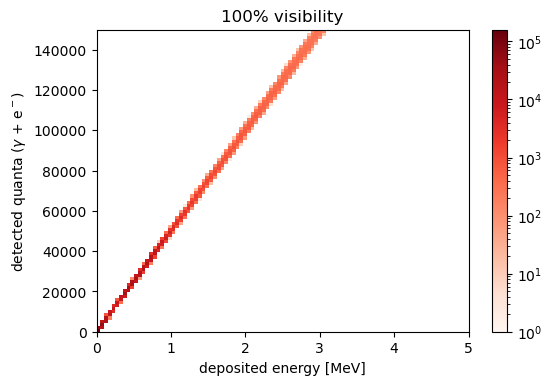

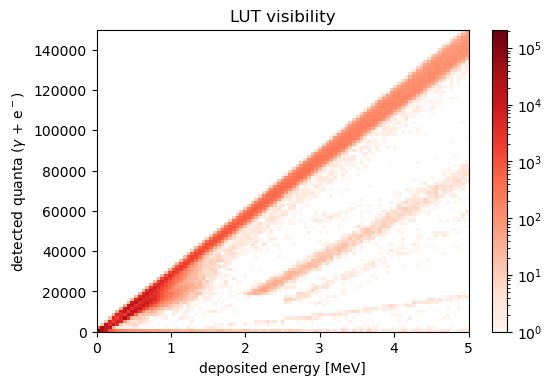

In [9]:
%matplotlib inline
bins = (np.linspace(0,5,100),np.linspace(0,1.5e5,100))
plt.figure(dpi=100)
plt.hist2d(tracks['dE'],
           tracks['n_photons'] + tracks['n_electrons'],
           bins=bins, cmap='Reds', norm=colors.LogNorm())
plt.xlabel('deposited energy [MeV]')
plt.ylabel(r'detected quanta ($\gamma$ + e$^-$)')
plt.title('100% visibility')
plt.colorbar()

plt.figure(dpi=100)
plt.hist2d(tracks['dE'],
           light_sim_dat['n_photons_det'].sum(axis=-1) + tracks['n_electrons'],
           bins=bins, cmap='Reds', norm=colors.LogNorm())
plt.xlabel('deposited energy [MeV]')
plt.ylabel(r'detected quanta ($\gamma$ + e$^-$)')
plt.title('LUT visibility')
plt.colorbar()

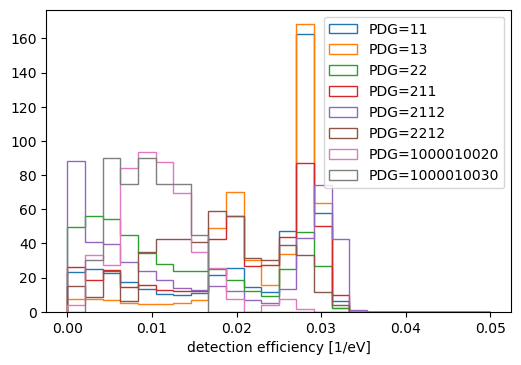

In [10]:
mask = (tracks['dE'] > 0)
plt.figure(dpi=100)
for id_ in np.unique(np.abs(tracks['pdgId'][mask])):
    submask = mask & (np.abs(tracks['pdgId']) == id_)
    plt.hist(1e-6 * (light_sim_dat['n_photons_det'].sum(axis=-1) + tracks['n_electrons'])[submask] / tracks['dE'][submask],
            bins=np.linspace(0,0.05,25), label=f'PDG={id_}', histtype='step', density=True)
plt.xlabel(r'detection efficiency [1/eV]')
plt.legend()

In [11]:
ievd = 2598

In [12]:
# copy paste from simulate_pixels.py

# create a lookup table that maps between unique event ids and the segments in the file
tot_evids = np.unique(tracks['eventID'])
_, _, start_idx = np.intersect1d(tot_evids, tracks['eventID'], return_indices=True)
_, _, rev_idx = np.intersect1d(tot_evids, tracks['eventID'][::-1], return_indices=True)
end_idx = len(tracks['eventID']) - 1 - rev_idx

# We divide the sample in portions that can be processed by the GPU
step = 1

# pre-allocate some random number states
rng_states = maybe_create_rng_states(1024*256, seed=0)
t0 = 0


event_id_list = []
adc_tot_list = []
adc_tot_ticks_list = []
track_pixel_map_tot = []
unique_pix_tot = []
current_fractions_tot = []

first_event = tot_evids[ievd]
last_event = tot_evids[min(ievd+step, tot_evids.shape[0]-1)]

if first_event == last_event:
    last_event += 1

# load a subset of segments from the file and process those that are from the current event
track_subset = tracks[min(start_idx[ievd:ievd + step]):max(end_idx[ievd:ievd + step])+1]
evt_tracks = track_subset[(track_subset['eventID'] >= first_event) & (track_subset['eventID'] < last_event)]
first_trk_id = np.where(track_subset['eventID'] == evt_tracks['eventID'][0])[0][0] + min(start_idx[ievd:ievd + step])

for itrk in tqdm(range(0, evt_tracks.shape[0], BATCH_SIZE), desc='  Simulating event %i batches...' % ievd, leave=False, ncols=80):
    selected_tracks = evt_tracks[itrk:itrk+BATCH_SIZE]
    RangePush("event_id_map")
    event_ids = selected_tracks['eventID']
    unique_eventIDs = np.unique(event_ids)
    RangePop()

    # We find the pixels intersected by the projection of the tracks on
    # the anode plane using the Bresenham's algorithm. We also take into
    # account the neighboring pixels, due to the transverse diffusion of the charges.
    RangePush("pixels_from_track")
    max_radius = ceil(max(selected_tracks["tran_diff"])*5/detector.PIXEL_PITCH)

    TPB = 128
    BPG = ceil(selected_tracks.shape[0] / TPB)
    max_pixels = np.array([0])
    pixels_from_track.max_pixels[BPG,TPB](selected_tracks, max_pixels)

    # This formula tries to estimate the maximum number of pixels which can have
    # a current induced on them.
    max_neighboring_pixels = (2*max_radius+1)*max_pixels[0]+(1+2*max_radius)*max_radius*2

    active_pixels = cp.full((selected_tracks.shape[0], max_pixels[0]), -1, dtype=np.int32)
    neighboring_pixels = cp.full((selected_tracks.shape[0], max_neighboring_pixels), -1, dtype=np.int32)
    n_pixels_list = cp.zeros(shape=(selected_tracks.shape[0]))

    if not active_pixels.shape[1] or not neighboring_pixels.shape[1]:
        continue

    pixels_from_track.get_pixels[BPG,TPB](selected_tracks,
                                          active_pixels,
                                          neighboring_pixels,
                                          n_pixels_list,
                                          max_radius)
    RangePop()

    RangePush("unique_pix")
    shapes = neighboring_pixels.shape
    joined = neighboring_pixels.reshape(shapes[0] * shapes[1])
    unique_pix = cp.unique(joined)
    unique_pix = unique_pix[(unique_pix != -1)]
    RangePop()

    if not unique_pix.shape[0]:
        continue

    RangePush("time_intervals")
    # Here we find the longest signal in time and we store an array with the start in time of each track
    max_length = cp.array([0])
    track_starts = cp.empty(selected_tracks.shape[0])
    detsim.time_intervals[BPG,TPB](track_starts, max_length, selected_tracks)
    RangePop()

    RangePush("tracks_current")
    # Here we calculate the induced current on each pixel
    signals = cp.zeros((selected_tracks.shape[0],
                        neighboring_pixels.shape[1],
                        cp.asnumpy(max_length)[0]), dtype=np.float32)
    TPB = (1,1,64)
    BPG_X = ceil(signals.shape[0] / TPB[0])
    BPG_Y = ceil(signals.shape[1] / TPB[1])
    BPG_Z = ceil(signals.shape[2] / TPB[2])
    BPG = (BPG_X, BPG_Y, BPG_Z)
    rng_states = maybe_create_rng_states(int(np.prod(TPB[:2]) * np.prod(BPG[:2])), seed=SEED+ievd+itrk, rng_states=rng_states)
    detsim.tracks_current_mc[BPG,TPB](signals, neighboring_pixels, selected_tracks, response, rng_states)
    RangePop()

    RangePush("pixel_index_map")
    # Here we create a map between tracks and index in the unique pixel array
    pixel_index_map = cp.full((selected_tracks.shape[0], neighboring_pixels.shape[1]), -1)
    for i_ in range(selected_tracks.shape[0]):
        compare = neighboring_pixels[i_, ..., cp.newaxis] == unique_pix
        indices = cp.where(compare)
        pixel_index_map[i_, indices[0]] = indices[1]
    RangePop()

    RangePush("track_pixel_map")
    # Mapping between unique pixel array and track array index
    track_pixel_map = cp.full((unique_pix.shape[0], detsim.MAX_TRACKS_PER_PIXEL), -1)
    TPB = 32
    BPG = ceil(unique_pix.shape[0] / TPB)
    detsim.get_track_pixel_map[BPG, TPB](track_pixel_map, unique_pix, neighboring_pixels)
    RangePop()

    RangePush("sum_pixels_signals")
    # Here we combine the induced current on the same pixels by different tracks
    TPB = (8,8,8)
    BPG_X = ceil(signals.shape[0] / TPB[0])
    BPG_Y = ceil(signals.shape[1] / TPB[1])
    BPG_Z = ceil(signals.shape[2] / TPB[2])
    BPG = (BPG_X, BPG_Y, BPG_Z)
    pixels_signals = cp.zeros((len(unique_pix), len(detector.TIME_TICKS)))
    pixels_tracks_signals = cp.zeros((len(unique_pix),
                                      len(detector.TIME_TICKS),
                                      track_pixel_map.shape[1]))
    detsim.sum_pixel_signals[BPG,TPB](pixels_signals,
                                      signals,
                                      track_starts,
                                      pixel_index_map,
                                      track_pixel_map,
                                      pixels_tracks_signals)
    RangePop()

    RangePush("get_adc_values")
    # Here we simulate the electronics response (the self-triggering cycle) and the signal digitization
    time_ticks = cp.linspace(0, len(unique_eventIDs) * detector.TIME_INTERVAL[1], pixels_signals.shape[1]+1)
    integral_list = cp.zeros((pixels_signals.shape[0], fee.MAX_ADC_VALUES))
    adc_ticks_list = cp.zeros((pixels_signals.shape[0], fee.MAX_ADC_VALUES))
    current_fractions = cp.zeros((pixels_signals.shape[0], fee.MAX_ADC_VALUES, track_pixel_map.shape[1]))

    TPB = 128
    BPG = ceil(pixels_signals.shape[0] / TPB)
    rng_states = maybe_create_rng_states(int(TPB * BPG), seed=SEED+ievd+itrk, rng_states=rng_states)
    pixel_thresholds_lut.tpb = TPB
    pixel_thresholds_lut.bpg = BPG
    pixel_thresholds = pixel_thresholds_lut[unique_pix.ravel()].reshape(unique_pix.shape)

    fee.get_adc_values[BPG, TPB](pixels_signals,
                                 pixels_tracks_signals,
                                 time_ticks,
                                 integral_list,
                                 adc_ticks_list,
                                 0,
                                 rng_states,
                                 current_fractions,
                                 pixel_thresholds)

    adc_list = fee.digitize(integral_list)
    adc_event_ids = np.full(adc_list.shape, unique_eventIDs[0]) # FIXME: only works if looping on a single event
    RangePop()

  Simulating event 2598 batches...:   0%|                 | 0/1 [00:00<?, ?it/s]/global/homes/p/pmadigan/.conda/envs/larnd-sim-2/lib/python3.9/site-packages/numba/cuda/compiler.py:726: NumbaPerformanceWarning: Grid size (1) < 2 * SM count (216) will likely result in GPU under utilization due to low occupancy.
  warn(NumbaPerformanceWarning(msg))
/global/homes/p/pmadigan/.conda/envs/larnd-sim-2/lib/python3.9/site-packages/numba/cuda/cudadrv/devicearray.py:885: NumbaPerformanceWarning: Host array used in CUDA kernel will incur copy overhead to/from device.
  warn(NumbaPerformanceWarning(msg))
/global/homes/p/pmadigan/.conda/envs/larnd-sim-2/lib/python3.9/site-packages/numba/cuda/compiler.py:726: NumbaPerformanceWarning: Grid size (1) < 2 * SM count (216) will likely result in GPU under utilization due to low occupancy.
  warn(NumbaPerformanceWarning(msg))
/global/homes/p/pmadigan/.conda/envs/larnd-sim-2/lib/python3.9/site-packages/numba/cuda/cudadrv/devicearray.py:885: NumbaPerformanceWa

Text(0, 0.5, 'energy [MeV]')

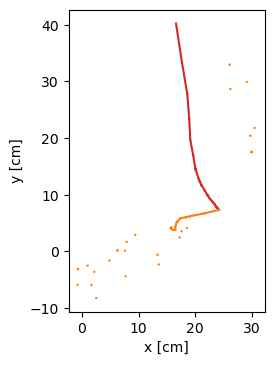

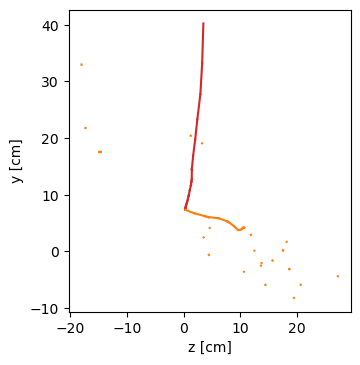

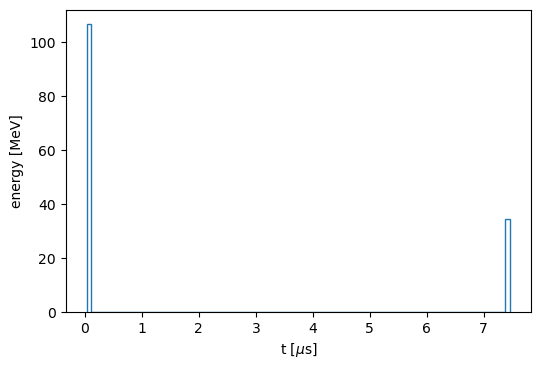

In [13]:
plt.figure(dpi=100)
for t in selected_tracks:
    plt.plot([t['x_start'], t['x_end']],
             [t['y_start'], t['y_end']],
             color=f'C{int(abs(t["pdgId"]))}')
plt.xlabel('x [cm]')
plt.ylabel('y [cm]')
plt.gca().set_aspect('equal')

plt.figure(dpi=100)
for t in selected_tracks:
    plt.plot([t['z_start'], t['z_end']],
             [t['y_start'], t['y_end']],
             color=f'C{int(abs(t["pdgId"]))}')
plt.xlabel('z [cm]')
plt.ylabel('y [cm]')
plt.gca().set_aspect('equal')

plt.figure(dpi=100)
plt.hist(selected_tracks['t0'], weights=selected_tracks['dE'], 
         histtype='step',
         bins=np.linspace(selected_tracks['t0'].min(), selected_tracks['t0'].max(), 100))
plt.xlabel(r't [$\mu$s]')
plt.ylabel('energy [MeV]')
# plt.xlim(0,1)

In [14]:
RangePush("sum_light_signals")
light_inc = light_sim_dat[itrk:itrk+BATCH_SIZE]
n_light_ticks, light_t_start = light_sim.get_nticks(light_inc)
n_light_det = light_inc.shape[-1]
light_sample_inc = cp.zeros((n_light_det,n_light_ticks), dtype='f4')
TPB = (1,64)
BPG = (ceil(light_sample_inc.shape[0] / TPB[0]),
       ceil(light_sample_inc.shape[1] / TPB[1]))
light_sim.sum_light_signals[BPG, TPB](selected_tracks, track_light_voxel[itrk:itrk+BATCH_SIZE], light_inc, 
                                      lut, light_t_start, light_sample_inc)
RangePop()

/global/homes/p/pmadigan/.conda/envs/larnd-sim-2/lib/python3.9/site-packages/numba/cuda/cudadrv/devicearray.py:885: NumbaPerformanceWarning: Host array used in CUDA kernel will incur copy overhead to/from device.
  warn(NumbaPerformanceWarning(msg))


In [15]:
light_sample_inc.shape

(96, 3650)

/tmp/ipykernel_103064/1708775587.py:1: MatplotlibDeprecationWarning: 
The mpl_toolkits.axes_grid module was deprecated in Matplotlib 2.1 and will be removed two minor releases later. Use mpl_toolkits.axes_grid1 and mpl_toolkits.axisartist, which provide the same functionality instead.
  from mpl_toolkits.axes_grid.inset_locator import inset_axes, mark_inset


(<mpl_toolkits.axes_grid1.inset_locator.BboxPatch at 0x7f3ded9c3cd0>,
 <mpl_toolkits.axes_grid1.inset_locator.BboxConnector at 0x7f3ded975d90>)

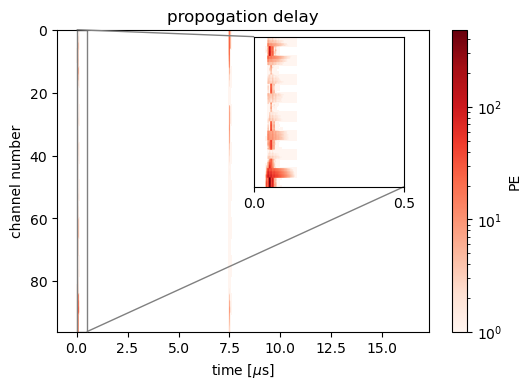

In [16]:
from mpl_toolkits.axes_grid.inset_locator import inset_axes, mark_inset

extent = (light_t_start,light_t_start+LIGHT_TICK_SIZE*light_sample_inc.shape[1],light_sample_inc.shape[0],0)
plt.figure(dpi=100)
plt.imshow(light_sample_inc.get(), cmap='Reds', 
           norm=colors.LogNorm(1),
           extent=extent,
           aspect='auto')
plt.ylabel('channel number')
plt.xlabel(r'time [$\mu$s]')
plt.colorbar(label='PE')
plt.title('propogation delay')
# plt.xlim(0,1)

ax = plt.gca()
ax_zoom = inset_axes(ax, width='50%', height=1.5, loc=1)
ax_zoom.imshow(light_sample_inc.get(), cmap='Reds', 
           norm=colors.LogNorm(1),
           extent=extent, origin='lower',
           aspect='auto')
ax_zoom.set_xlim(0, 0.5)
ax_zoom.set_ylim(0, light_sample_inc.shape[0])
ax_zoom.set_xticks([0,0.5])
ax_zoom.set_yticks([])
ax_zoom.set_aspect(0.5/light_sample_inc.shape[0])

mark_inset(ax, ax_zoom, loc1=2, loc2=4, ec='0.5')

In [17]:
RangePush("sim_scintillation")
light_sample_inc_scint = cp.zeros_like(light_sample_inc)
light_sim.calc_scintillation_effect[BPG, TPB](light_sample_inc, light_sample_inc_scint)

light_sample_inc_disc = cp.zeros_like(light_sample_inc)
rng_states = maybe_create_rng_states(int(np.prod(TPB) * np.prod(BPG)), seed=SEED+ievd+itrk, rng_states=rng_states)
light_sim.calc_stat_fluctuations[BPG, TPB](light_sample_inc_scint, light_sample_inc_disc, rng_states)
RangePop()

/global/homes/p/pmadigan/.conda/envs/larnd-sim-2/lib/python3.9/site-packages/numba/cuda/compiler.py:726: NumbaPerformanceWarning: Grid size (92) < 2 * SM count (216) will likely result in GPU under utilization due to low occupancy.
  warn(NumbaPerformanceWarning(msg))


(<mpl_toolkits.axes_grid1.inset_locator.BboxPatch at 0x7f3dede7f400>,
 <mpl_toolkits.axes_grid1.inset_locator.BboxConnector at 0x7f3dede82490>)

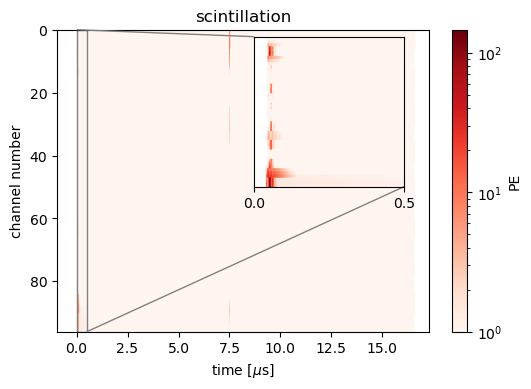

In [18]:
extent=(light_t_start,light_t_start+LIGHT_TICK_SIZE*light_sample_inc_scint.shape[1],light_sample_inc_scint.shape[0],0)

plt.figure(dpi=100)
plt.imshow(light_sample_inc_scint.get(), cmap='Reds', 
           norm=colors.LogNorm(1),
           extent=extent,
           aspect='auto')
plt.ylabel('channel number')
plt.xlabel(r'time [$\mu$s]')
plt.colorbar(label='PE')
plt.title('scintillation')
# plt.xlim(0,2.5)

ax = plt.gca()
ax_zoom = inset_axes(ax, width='50%', height=1.5, loc=1)
ax_zoom.imshow(light_sample_inc_scint.get(), cmap='Reds', 
           norm=colors.LogNorm(1),
           extent=extent, origin='lower',
           aspect='auto')
ax_zoom.set_xlim(0, 0.5)
ax_zoom.set_ylim(0, light_sample_inc_scint.shape[0])
ax_zoom.set_xticks([0,0.5])
ax_zoom.set_yticks([])
ax_zoom.set_aspect(0.5/light_sample_inc_scint.shape[0])

mark_inset(ax, ax_zoom, loc1=2, loc2=4, ec='0.5')

(<mpl_toolkits.axes_grid1.inset_locator.BboxPatch at 0x7f3ded6717f0>,
 <mpl_toolkits.axes_grid1.inset_locator.BboxConnector at 0x7f3ded622820>)

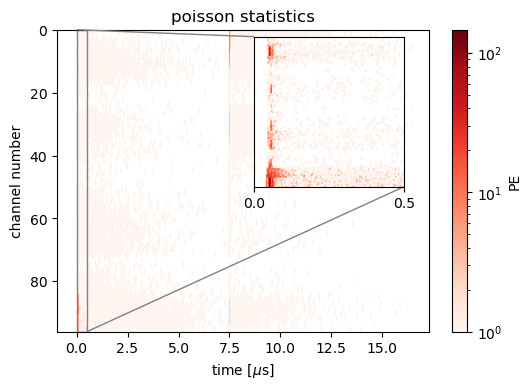

In [19]:
plt.figure(dpi=100)
plt.imshow(light_sample_inc_disc.get(), cmap='Reds', 
           norm=colors.LogNorm(1),
           extent=(light_t_start,light_t_start+LIGHT_TICK_SIZE*light_sample_inc_disc.shape[1],light_sample_inc_disc.shape[0],0),
           aspect='auto')
plt.ylabel('channel number')
plt.xlabel(r'time [$\mu$s]')
plt.colorbar(label='PE')
plt.title('poisson statistics')
# plt.xlim(0,2.5)

ax = plt.gca()
ax_zoom = inset_axes(ax, width='50%', height=1.5, loc=1)
ax_zoom.imshow(light_sample_inc_disc.get(), cmap='Reds', 
           norm=colors.LogNorm(1),
           extent=extent, origin='lower',
           aspect='auto')
ax_zoom.set_xlim(0, 0.5)
ax_zoom.set_ylim(0, light_sample_inc_disc.shape[0])
ax_zoom.set_xticks([0,0.5])
ax_zoom.set_yticks([])
ax_zoom.set_aspect(0.5/light_sample_inc_disc.shape[0])

mark_inset(ax, ax_zoom, loc1=2, loc2=4, ec='0.5')

In [20]:
RangePush("sim_light_det_response")
light_noise = cp.load(light_det_noise_filename)
light_response = cp.zeros_like(light_sample_inc)
light_sim.calc_light_detector_response[BPG, TPB](light_sample_inc_disc, light_response)
light_response += light_sim.gen_light_detector_noise(light_response.shape, light_noise)
RangePop()

In [21]:
trigger_idx = light_sim.get_triggers(light_response)

In [22]:
digit_samples = ceil((LIGHT_TRIG_WINDOW[1]+LIGHT_TRIG_WINDOW[0])/LIGHT_DIGIT_SAMPLE_SPACING)
TPB = (1,1,64)
BPG = (ceil(trigger_idx.shape[0] / TPB[0]),
       ceil(light_response.shape[0] / TPB[1]),
       ceil(digit_samples / TPB[2]))
light_digit_signal = light_sim.sim_triggers(BPG, TPB, light_response, trigger_idx, digit_samples, light_noise)

(<mpl_toolkits.axes_grid1.inset_locator.BboxPatch at 0x7f3ded2c5d90>,
 <mpl_toolkits.axes_grid1.inset_locator.BboxConnector at 0x7f3ded308070>)

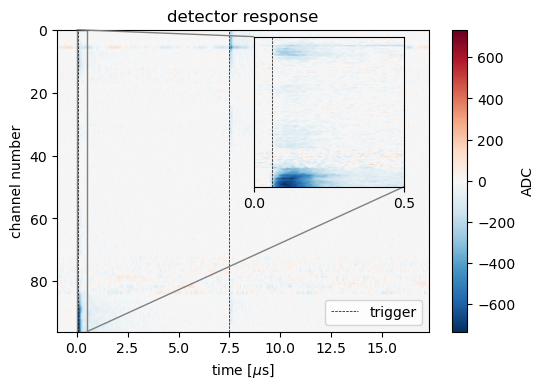

In [23]:
extent = (light_t_start,light_t_start+LIGHT_TICK_SIZE*light_response.shape[1],light_response.shape[0],0)
plt.figure(dpi=100)
plt.imshow(light_response.get(), cmap='RdBu_r', 
           norm=colors.CenteredNorm(),
           extent=extent,
           aspect='auto')
for itrig in trigger_idx.get():
    plt.axvline(itrig * LIGHT_TICK_SIZE + light_t_start, color='k', ls='--', lw=0.5)
plt.ylabel('channel number')
plt.xlabel(r'time [$\mu$s]')
plt.colorbar(label='ADC')
plt.title('detector response')
plt.legend(['trigger'], loc='lower right')
# plt.xlim(0,3)

ax = plt.gca()
ax_zoom = inset_axes(ax, width='50%', height=1.5, loc=1)
ax_zoom.imshow(light_response.get(), cmap='RdBu_r', 
           norm=colors.CenteredNorm(),
           extent=extent, origin='lower',
           aspect='auto')
for itrig in trigger_idx.get():
    ax_zoom.axvline(itrig * LIGHT_TICK_SIZE + light_t_start, color='k', ls='--', lw=0.5)
ax_zoom.set_xlim(0, 0.5)
ax_zoom.set_ylim(0, light_response.shape[0])
ax_zoom.set_xticks([0,0.5])
ax_zoom.set_yticks([])
ax_zoom.set_aspect(0.5/light_response.shape[0])

mark_inset(ax, ax_zoom, loc1=2, loc2=4, ec='0.5')

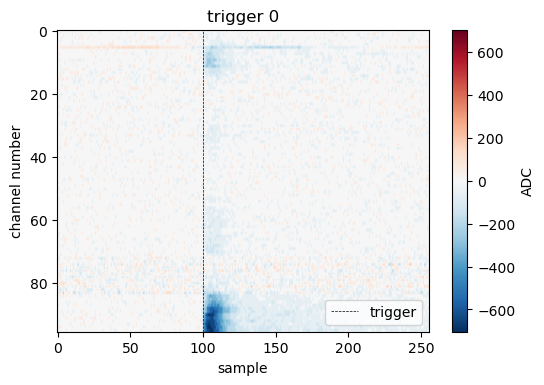

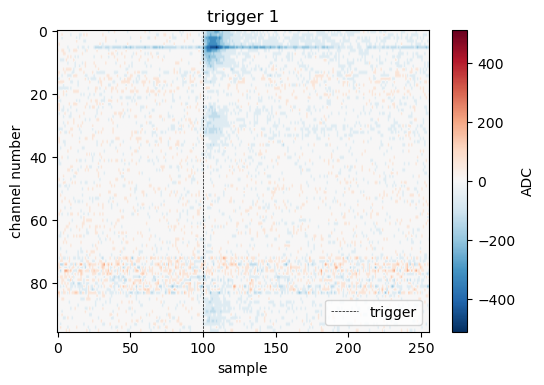

In [24]:
for itrig in range(0,light_digit_signal.shape[0]):
    plt.figure(dpi=100)
    plt.imshow(light_digit_signal[itrig].get(), cmap='RdBu_r', norm=colors.CenteredNorm(), aspect='auto')
    plt.xlabel('sample')
    plt.ylabel('channel number')
    plt.title(f'trigger {itrig}')
    plt.colorbar(label='ADC')
    plt.axvline(LIGHT_TRIG_WINDOW[0] / LIGHT_DIGIT_SAMPLE_SPACING, color='k', ls='--', lw=0.5)
    plt.legend(['trigger'], loc='lower right')

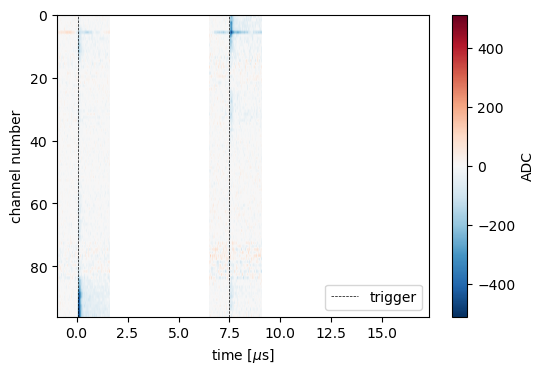

In [25]:
plt.figure(dpi=100)
for itrig in range(0,light_digit_signal.shape[0]):
    extent = (light_t_start + trigger_idx[itrig].get() * LIGHT_TICK_SIZE - LIGHT_TRIG_WINDOW[0],
              light_t_start + trigger_idx[itrig].get() * LIGHT_TICK_SIZE + LIGHT_TRIG_WINDOW[1],
              light_digit_signal.shape[1], 0)
    plt.imshow(light_digit_signal[itrig].get(), cmap='RdBu_r', norm=colors.CenteredNorm(), aspect='auto', extent=extent)
for itrig in trigger_idx.get():
    plt.axvline(itrig * LIGHT_TICK_SIZE + light_t_start, color='k', ls='--', lw=0.5)
plt.xlim(light_t_start, light_t_start + n_light_ticks * LIGHT_TICK_SIZE)
plt.xlabel(r'time [$\mu$s]')
plt.ylabel('channel number')
plt.legend(['trigger'], loc='lower right')
# plt.title(f'trigger {itrig}')
plt.colorbar(label='ADC')

In [43]:
import h5py
f = h5py.File('../larndsim.9951.h5','r')

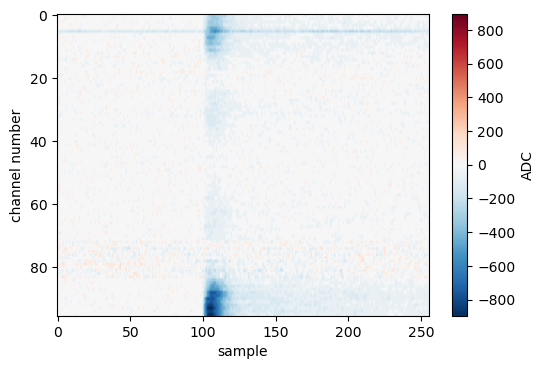

In [44]:
plt.figure(dpi=100)
plt.imshow(f['light_wvfm'][0], cmap='RdBu_r', norm=colors.CenteredNorm(), aspect='auto')
plt.xlabel('sample')
plt.ylabel('channel number')
plt.colorbar(label='ADC')

In [45]:
np.unique(f['packets'][:][['packet_type','io_group']])

array([(0, 1), (0, 2), (4, 0), (6, 1), (6, 2), (7, 1), (7, 2)],
      dtype={'names':['packet_type','io_group'], 'formats':['u1','u1'], 'offsets':[3,0], 'itemsize':36})

In [46]:
mask = (f['packets']['packet_type'] == 7)
print('LArPix trigger packets:\t', f['packets'][mask]['timestamp'][:100])
print('Light triggers:\t\t', f['light_trig']['ts_sync'][:100])

mask = (f['packets']['packet_type'] == 4)
print('LArPix timestamp packets:\t', f['packets'][mask]['timestamp'][:100])
print('Light triggers:\t\t', f['light_trig']['ts_s'][:100])

LArPix trigger packets:	 [  334604   334604   427136   427136  4731890  4731890  9530059  9530059
 11263400 11263400 11885565 11885565 13452375 13452375 14356227 14356227
 15096949 15096949]
Light triggers:		 [  334604   427136  4731890  9530059 11263400 11885565 13452375 14356227
 15096949]
LArPix timestamp packets:	 [0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1]
Light triggers:		 [0.03346047 0.04271378 0.47318913 0.95300605 1.12634016 1.18855664
 1.34523757 1.43562287 1.50969503]
